In [2]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5

   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------  284.2/284.2 MB 3.1 MB/s eta 0:00:01
   -------------------------------------

In [3]:
import librosa
from sklearn.model_selection import train_test_split
import numpy as np
#TODO
#Ver si vamos a usar Drive para los datasets
#from google.colab import drive
import os
import json
import tensorflow.keras as keras
import pickle #Para exportar el modelo

In [4]:
#drive.mount('/content/drive')

In [32]:
#TODO
#Definir el path de los datos
data_path = "json_data_audio_cut.json"
epochs = 40 #Cantidad de ciclos completos de entrenamiento de todos los datos 
batch_size = 16 #Cantidad de datos utilizados en las iteraciones de entrenamientos
num_keywords = 2 #Numero de outputs, categorias
neuronas_por_capa = 128

In [6]:
def load_dataset(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

  #Transformamos las filas de mfcc y labels que estaban como listas a numpay arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [7]:
def get_data_splits(data_path, test_size = 0.2, test_validation_size = 0.1):
  #cargamos el dataset
    X, y = load_dataset(data_path)

  #creamos los train/validation/test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = test_validation_size )

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [9]:
def predict(X, y, model):
    X = X[np.newaxis, ...]
    prediccion = model.predict(X)
    prediccion = np.argmax(prediccion, axis=1)
    print(f"Esperado: {y} Prediccion: {prediccion}")


In [134]:
def build_model(input_shape):
  #RNN
  #build network
    model = keras.Sequential()

  #lstm layer 1
    model.add(keras.layers.LSTM(neuronas_por_capa, input_shape = input_shape, return_sequences = True,kernel_regularizer=keras.regularizers.l2(0.005)))

  #lstm layer 2 recibe la secuencia de layer 1, pero ahora devuelve un vector
    model.add(keras.layers.LSTM(neuronas_por_capa,kernel_regularizer=keras.regularizers.l2(0.005)))
    model.add(keras.layers.Dropout(0.6))

  #dense layer
    model.add(keras.layers.Dense(neuronas_por_capa/2, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.005)))
    model.add(keras.layers.Dropout(0.6))
    
    model.add(keras.layers.Dense(neuronas_por_capa/4, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.005)))
    model.add(keras.layers.Dropout(0.6))

  #para reducir overfitting
   # model.add(keras.layers.Dropout(0.3))

  #softmax classifier
    model.add(keras.layers.Dense(num_keywords, activation = "softmax"))
  #compile the model

    return model

Cargar datos de entrenamiento/validacion/testeo

In [64]:
X_train, X_validation, X_test, y_train, y_validation, y_test = get_data_splits(data_path) 

Modelo

In [135]:
input_shape = (X_train.shape[1], X_train.shape[2]) #Es la forma de input que la RNN espera recibir
model = build_model(input_shape)

In [136]:
optimizador = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizador,
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]) #metrics despues nos ayudara a visualizar la precision con model.fit

Entrenar

In [137]:
training_information = model.fit(X_train,
          y_train,
          epochs = epochs,
          batch_size = batch_size,
          validation_data = (X_validation, y_validation)
          )          #validation_data = (X_validation, y_validation)

Epoch 1/40
90/90 [==============================] - 30s 258ms/step - loss: 2.3121 - accuracy: 0.6685 - val_loss: 2.0813 - val_accuracy: 0.8616
Epoch 2/40
90/90 [==============================] - 22s 244ms/step - loss: 2.0857 - accuracy: 0.7790 - val_loss: 1.8935 - val_accuracy: 0.8616
Epoch 3/40
90/90 [==============================] - 22s 244ms/step - loss: 1.9473 - accuracy: 0.8091 - val_loss: 1.7483 - val_accuracy: 0.8616
Epoch 4/40
90/90 [==============================] - 23s 254ms/step - loss: 1.8405 - accuracy: 0.8154 - val_loss: 1.6323 - val_accuracy: 0.8679
Epoch 5/40
90/90 [==============================] - 23s 255ms/step - loss: 1.6991 - accuracy: 0.8259 - val_loss: 1.5363 - val_accuracy: 0.8868
Epoch 6/40
90/90 [==============================] - 23s 256ms/step - loss: 1.5864 - accuracy: 0.8566 - val_loss: 1.4414 - val_accuracy: 0.9119
Epoch 7/40
90/90 [==============================] - 23s 257ms/step - loss: 1.4764 - accuracy: 0.8643 - val_loss: 1.3644 - val_accuracy: 0.9182

Guardar modelo para usarlo luego sin tener que volver a entrenarlo

In [160]:
test_error, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test error: {test_error}, test accuracy: {test_accuracy}")

13/13 [==============================] - 2s 129ms/step - loss: 0.6567 - accuracy: 0.9472
Test error: 0.6566852331161499, test accuracy: 0.947236180305481


In [161]:
print(X_test.size)
print(y_test.size)

1117584
398


In [162]:
X = X_test[1] #Cualquiera en el de test
y = y_test[1]
predict(X, y, model)

1/1 [==============================] - 1s 1s/step
Esperado: 0 Prediccion: [0]


In [163]:
for i in range(y_test.size):
    X = X_test[i]
    y = y_test[i]
    predict(X, y, model)

1/1 [==============================] - 0s 63ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 71ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 74ms/step
Esperado: 1 Prediccion: [0]
1/1 [==============================] - 0s 79ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 65ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 76ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 80ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 88ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 71ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 80ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 89ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 68ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0

1/1 [==============================] - 0s 61ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 58ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 64ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 63ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 60ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 62ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 65ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 59ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 63ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 57ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 64ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 58ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0

1/1 [==============================] - 0s 62ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 59ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 61ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 60ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 63ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 63ms/step
Esperado: 0 Prediccion: [1]
1/1 [==============================] - 0s 63ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 62ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 64ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 66ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 65ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 66ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0

1/1 [==============================] - 0s 65ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 64ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 76ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 77ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 62ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 58ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 57ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 59ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0s 70ms/step
Esperado: 0 Prediccion: [1]
1/1 [==============================] - 0s 77ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 64ms/step
Esperado: 0 Prediccion: [0]
1/1 [==============================] - 0s 61ms/step
Esperado: 1 Prediccion: [1]
1/1 [==============================] - 0

In [140]:
X_train.shape[1]

216

In [141]:
X_train[1]

array([[-189.55085754,   -9.47005463,   47.37533569, ...,   -1.58322203,
          12.78938866,    2.39709783],
       [-170.00306702,  -20.92977905,   40.78568268, ...,   -8.46310043,
           9.03312492,    2.58308363],
       [-174.33618164,  -23.95780945,   43.41019821, ...,  -10.10815144,
           8.15743351,    2.29658198],
       ...,
       [-110.78853607,   -7.68596649,   17.71935654, ...,  -19.19799805,
          -9.09382439,  -12.78467655],
       [ -96.9595108 ,   53.13253403,   -9.26298714, ...,  -17.81422424,
          -6.29757404,  -13.48724937],
       [-113.84497833,  120.45072937,  -57.05881882, ...,   -6.53346062,
          -5.5128994 ,   -5.3122263 ]])

In [142]:
X_train.shape[2]

13

In [143]:
X_train[2]

array([[-3.45217560e+02,  1.37294479e+02, -1.63956108e+01, ...,
        -1.60395222e+01, -1.31272042e+00,  1.67849464e+01],
       [-3.43924133e+02,  1.29384308e+02, -2.12744331e+01, ...,
        -1.60732574e+01, -9.69481468e-02,  1.79518394e+01],
       [-3.73510498e+02,  1.15990005e+02, -2.24300194e+01, ...,
        -1.32358828e+01,  5.53136349e+00,  1.65393009e+01],
       ...,
       [-1.81460297e+02,  1.09536194e+02,  2.74055290e+00, ...,
        -2.44414759e+00,  6.89162350e+00,  1.52440381e+00],
       [-1.98393387e+02,  5.34651413e+01,  2.88231201e+01, ...,
        -4.53998470e+00,  9.26281738e+00,  5.19094563e+00],
       [-2.32022522e+02,  2.48820076e+01,  3.56332092e+01, ...,
        -7.45701122e+00,  4.72989798e+00,  9.99860382e+00]])

In [152]:
X_train.shape
#En este ejemplo, los datos significan que tengo 1430 listas de 216 mfcc

(1430, 216, 13)

In [145]:
y_train.shape

(1430,)

In [146]:
X_test.shape

(398, 216, 13)

In [147]:
y_test.shape

(398,)

In [155]:
X_train[1]

array([[-189.55085754,   -9.47005463,   47.37533569, ...,   -1.58322203,
          12.78938866,    2.39709783],
       [-170.00306702,  -20.92977905,   40.78568268, ...,   -8.46310043,
           9.03312492,    2.58308363],
       [-174.33618164,  -23.95780945,   43.41019821, ...,  -10.10815144,
           8.15743351,    2.29658198],
       ...,
       [-110.78853607,   -7.68596649,   17.71935654, ...,  -19.19799805,
          -9.09382439,  -12.78467655],
       [ -96.9595108 ,   53.13253403,   -9.26298714, ...,  -17.81422424,
          -6.29757404,  -13.48724937],
       [-113.84497833,  120.45072937,  -57.05881882, ...,   -6.53346062,
          -5.5128994 ,   -5.3122263 ]])

In [158]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

In [159]:
input_shape

(216, 13)

In [46]:
import matplotlib.pyplot as plt

In [73]:
def graficar(training_data):
    fig, axs = plt.subplots(2)
    axs[0].plot(training_data.history["accuracy"], label="train accuracy")
    axs[0].plot(training_data.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(training_data.history["loss"], label="train loss")
    axs[1].plot(training_data.history["val_loss"], label="test loss")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss eval")
    
    plt.show()

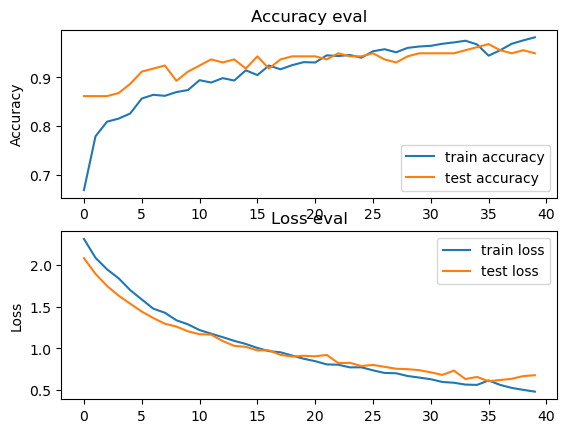

In [138]:
graficar(training_information)

In [139]:
#guardar el modelo
with open('audio_model_mejoras_10.pkl', 'wb') as handle:
    pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)


#model.save(save_path_model)